# Functions for Downloading and Caching the Dataset
The dictionary "DATA_HUB" maps a string (the name of the dataset) to a tuple containing both the URL to locate the dataset and the SHA-1 key (a unique "fingerprint" that can be used for signing in) that verifies the integrity of the file.

In [36]:
import os
import requests
import zipfile
import tarfile
import hashlib

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

The "download" function downloads the dataset and chaches it in a local directory. It'll communicate with the SHA-1 key to verify if the same download already exists to avoid redundancy.

In [37]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

We also implement two additional utility functions: one is to download and extract a zip or tar file and the other to download all the datasets used in this book from DATA_HUB into the cache directory.

In [38]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

# Wrangling the Dataset
The data are separated into training and test sets, with each record including the property value of the house and attributes such as street type, year of construction, roof type, basement condition, etc. Naturally, there are mixed data types and missing data, so these need to be accounted for. Let's partition the training set to create a validation set, and then test house price predictions on the test set.

In [39]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

Download and cache dataset.

In [40]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [41]:
# convert data to Pandas dataframes
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape,"1460 examples and 81 features")
print(test_data.shape,"1459 examples and 80 features")

(1460, 81) 1460 examples and 81 features
(1459, 80) 1459 examples and 80 features


In [42]:
# remove the first column, "Id", since it isn't needed for predictions
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [43]:
# replace missing numerical values with averages
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # normalize dataa
# set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [44]:
# replace missing discrete values via one-hot encoding
# transform multiclass labels into vectors
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
# note that the number of features from 79 to 331

(2919, 331)

Extract the NumPy format from the Pandas format and convert it into the tensor representation for training.

In [45]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# Training
Create a linear model with squared loss to serve as a baseline for accuracy, which we expect to be worse than the accuracy of our MLP model.

In [46]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

Calculate RMSE between the logarithm of the predicted price and the logarithm of the label price. This accounts for relative error, which is desired since absolute error will be detrimental to predictions (house prices in Ohio are far different from those in California).

In [47]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(torch.mean(loss(torch.log(clipped_preds),
                                       torch.log(labels))))
    return rmse.item()

In [48]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # use Adam optimization algorithm
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K-Fold Cross-Validation
Define a function that returns the  ith  fold of the data in a  K-fold cross-validation procedure. It will then slice out the  ith  segment as validation data and return the rest as training data.

In [49]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [50]:
# return training and verification errors after training K times
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# Model Tuning
First start by selecting arbitrary values for hyperparameters k, epochs, learning rate, weight decay, and batch size. We want the training error to closely trace the validation set error.

fold 1, train log rmse 0.165591, valid log rmse 0.160290
fold 2, train log rmse 0.166648, valid log rmse 0.152555
fold 3, train log rmse 0.153653, valid log rmse 0.220406
fold 4, train log rmse 0.165537, valid log rmse 0.135441
fold 5, train log rmse 0.161361, valid log rmse 0.163311
fold 6, train log rmse 0.167646, valid log rmse 0.181023
6-fold validation: avg train log rmse: 0.163406, avg valid log rmse: 0.168838


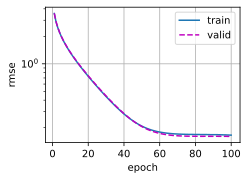

In [51]:
k, num_epochs, lr, weight_decay, batch_size = 6, 100, 6, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

# Apply Model to Test Set
Above, we used 1−1/K of the data that are used in the cross-validation slices, so let's now apply to the test set. The results are output to a .CSV file.

In [52]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = d2l.numpy(net(test_features))
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Ensure test set predictions resemble those of the k-fold cross-validation process.

train log rmse 0.156431


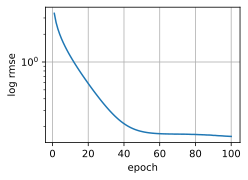

In [53]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

Compared to the real data, once submitted to Kaggle, we achieve an RMSE score of 0.16397, which is very much in line with our training and validation RMSE. Thus, additional turning to reduce the RMSE should lead to a reduction in predicted values versus actual values.